Epoch 1/100


c:\Users\KD\Desktop\Innovate48\in48\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 877ms/step - loss: 0.0891
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.0022
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.0012
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 6.8646e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 4.9487e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 3.3894e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 3.0057e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 997ms/step - loss: 2.6102e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 989ms/step - loss: 2.6949e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 2.8481e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 972ms/step - loss: 2.7501e-04
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 989ms/step - loss: 2.7832e-04
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 972ms/step - loss: 2.5946e-04
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 964ms/step - loss: 2.7814e-04
Epoch 15/100
25/25

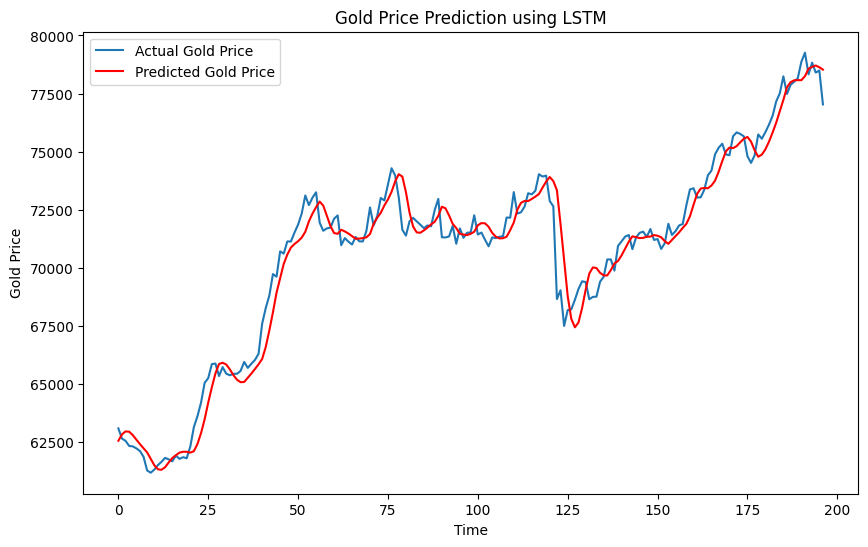

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("Gold Price.csv")

# Extract the date and closing price
data['Date'] = pd.to_datetime(data['Date'])
data= data.sort_values(by='Date', ascending=True)  # Sort by Date in ascending order
data=data.reset_index()

# Extract only the 'Price' column for prediction
gold_price = data['Price'].values

# Normalize the data (scaling it between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
gold_price_scaled = scaler.fit_transform(gold_price.reshape(-1, 1))

# Define the time step for sequences (using 5 years = 5 * 365 days)
time_step = 5 * 365

# Prepare the dataset for training (X: input, y: target)
X = []
y = []

for i in range(time_step, len(gold_price_scaled)):
    X.append(gold_price_scaled[i - time_step:i, 0])  # last 5 years
    y.append(gold_price_scaled[i, 0])  # next year's price

X = np.array(X)
y = np.array(y)

# Reshape X to be 3D [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()

# LSTM layer (use return_sequences=True to stack multiple LSTM layers)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer for the predicted price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Predict the next year's price using the test data
predictions_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the prediction errors
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)

# Display the errors
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Gold Price')
plt.plot(predictions, label='Predicted Gold Price', color='red')
plt.title('Gold Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend()
plt.show()


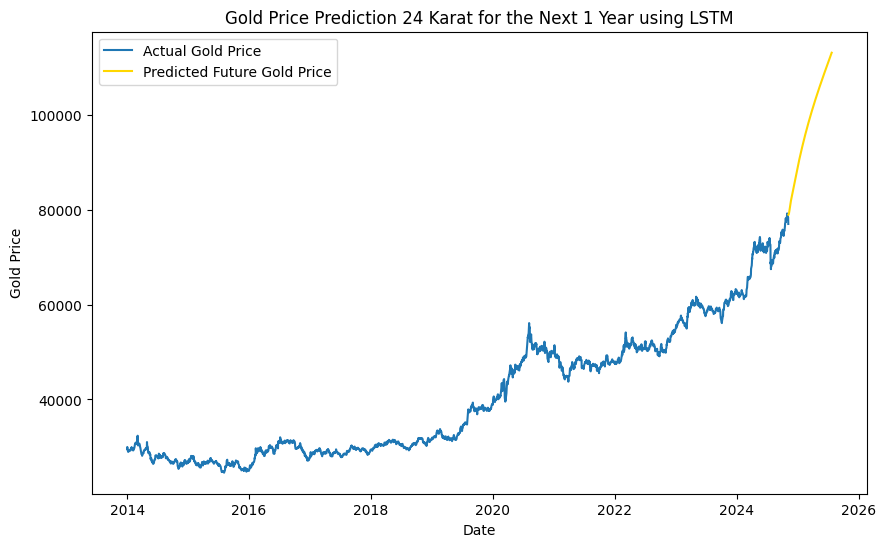

In [18]:
import tensorflow as tf
#uncomment below line for loading already saved model
#model = tf.keras.models.load_model('LSTM.h5') 
# Predict the next 1 year of gold prices (260 days)
future_days = 260

# Start by using the last 1 year of data as input
last_known_data = X[-1].reshape(1, time_step, 1)

# List to store the predictions for the next 1 year
future_predictions = []

for _ in range(future_days):
    # Predict the next day's gold price
    predicted_price = model.predict(last_known_data,verbose=0)
    
    # Append the predicted price to the future predictions list
    future_predictions.append(predicted_price[0][0])
    
    # Update the input for the next prediction: add the predicted price to the sequence
    last_known_data = np.append(last_known_data[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

# Inverse transform the predictions back to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate corresponding dates for the next 5 years
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=future_days + 1, freq='D')[1:]

# Plot the actual prices and the predicted future prices
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], gold_price, label='Actual Gold Price')
plt.plot(future_dates, future_predictions, label='Predicted Future Gold Price', color='gold')
plt.title('Gold Price Prediction 24 Karat for the Next 1 Year using LSTM')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()


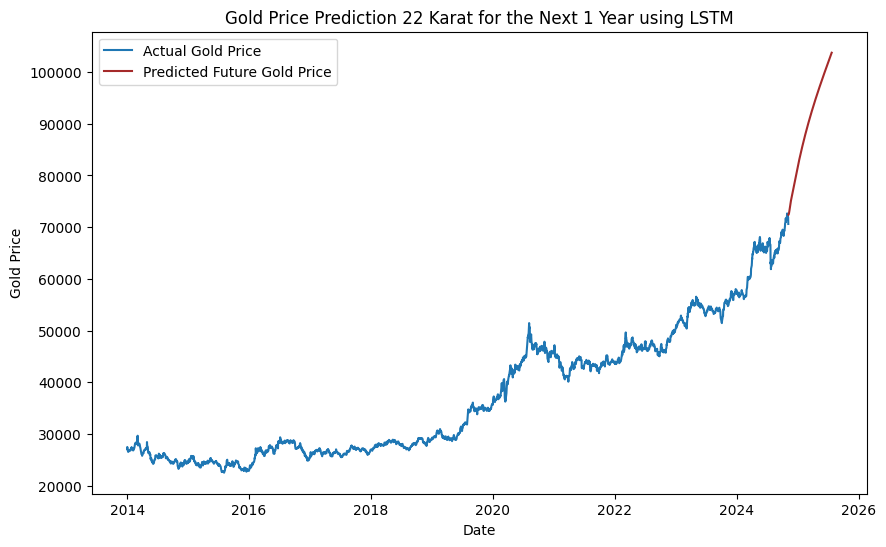

In [19]:
CONVERSION_FACTOR=0.9167
import tensorflow as tf
#uncomment below line for loading already saved model
#model = tf.keras.models.load_model('LSTM.h5') 
# Predict the next 1 year of gold prices (260 days)
future_days = 260

# Start by using the last 5 years of data as input
last_known_data = X[-1].reshape(1, time_step, 1)

# List to store the predictions for the next 1 year
future_predictions = []

for _ in range(future_days):
    # Predict the next day's gold price
    predicted_price = model.predict(last_known_data,verbose=0)
    
    # Append the predicted price to the future predictions list
    future_predictions.append(predicted_price[0][0])
    
    # Update the input for the next prediction: add the predicted price to the sequence
    last_known_data = np.append(last_known_data[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

# Inverse transform the predictions back to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate corresponding dates for the next 5 years
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=future_days + 1, freq='D')[1:]

# Plot the actual prices and the predicted future prices
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], gold_price*CONVERSION_FACTOR, label='Actual Gold Price')
plt.plot(future_dates, future_predictions*CONVERSION_FACTOR, label='Predicted Future Gold Price', color='brown')
plt.title('Gold Price Prediction 22 Karat for the Next 1 Year using LSTM')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()
